<a href="https://colab.research.google.com/github/zxcvmh/gfds/blob/cs_115/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
nimishmagre_tmnist_typeface_mnist_path = kagglehub.dataset_download('nimishmagre/tmnist-typeface-mnist')

print('Data source import complete.')


Using Colab cache for faster access to the 'tmnist-typeface-mnist' dataset.
Data source import complete.


In [7]:
# Nhập các thư viện cần thiết
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os
import keras_tuner as kt

from keras import models
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [8]:
data = pd.read_csv("/kaggle/input/tmnist-typeface-mnist/TMNIST_Data.csv") # dữ liệu mẫu

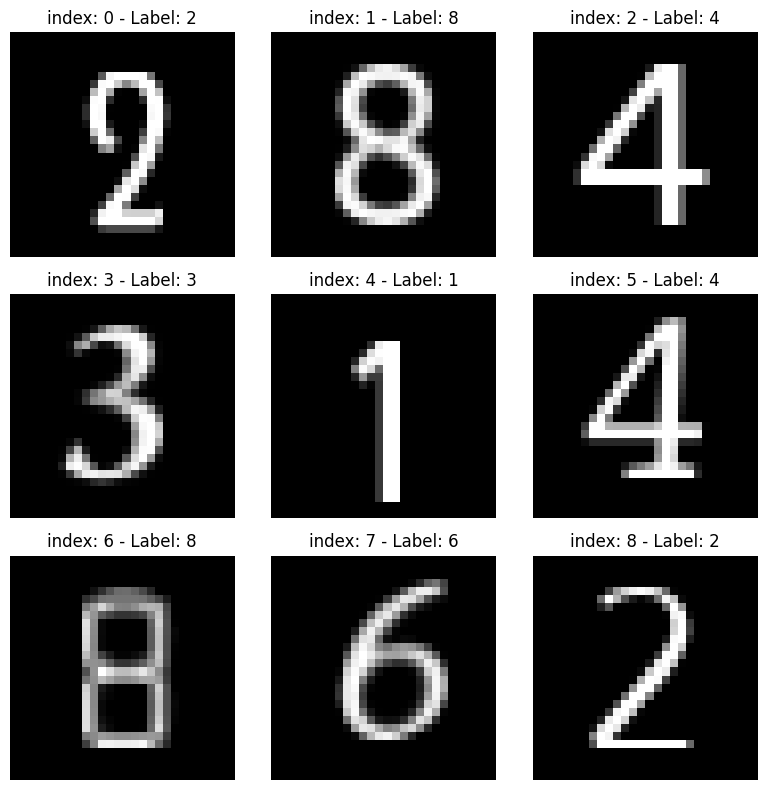

In [9]:
numeric_pixels = data.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(8, 8)) # Trình bày các số
for idx in range(9):
    plt.subplot(3, 3, idx + 1)
    digit_image = numeric_pixels.iloc[idx].values.reshape(28, 28)
    plt.imshow(digit_image, cmap='gray')

    plt.title(f'index: {idx} - Label: {data.iloc[idx, 1]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

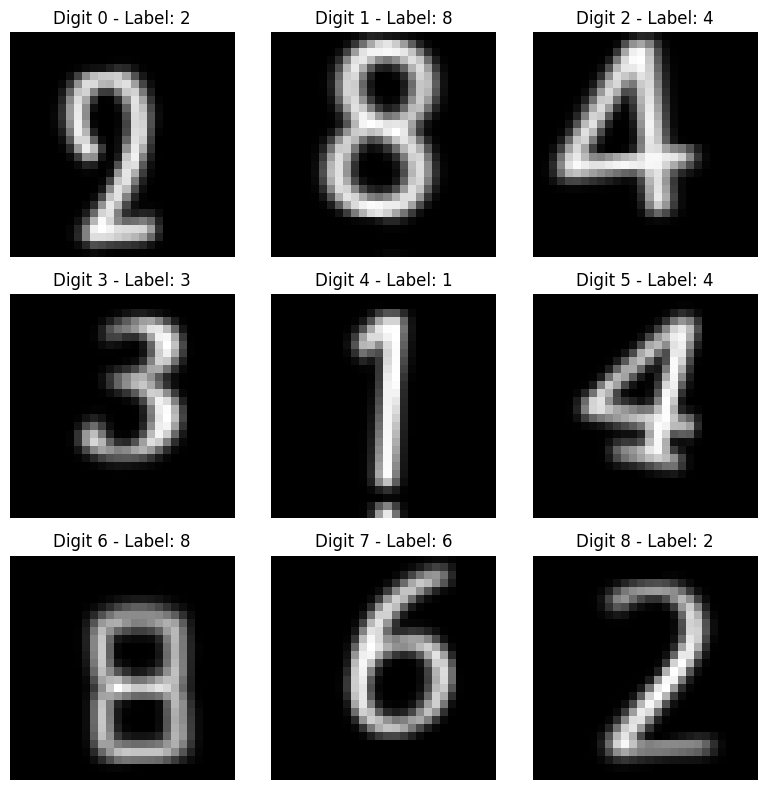

In [10]:
augment = keras.Sequential([ # Tăng cường dữ liệu
    layers.RandomRotation(factor = 0.03),
    layers.RandomZoom(height_factor = 0.1, width_factor = 0.1),
    layers.RandomTranslation(height_factor = 0.1, width_factor= 0.1)
])
plt.figure(figsize=(8, 8))
for idx in range(9):
    plt.subplot(3, 3, idx + 1)
    digit_image = numeric_pixels.iloc[idx].values.reshape(28, 28,-1)
    transform_image = augment(digit_image, training = True)
    plt.imshow(tf.squeeze(transform_image), cmap='gray')
    plt.title(f'Digit {idx} - Label: {data.iloc[idx, 1]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Tạo train và test
y = data.labels
X = data.drop(['labels','names'],axis=1)

X_images = X.values
X_images = X_images.reshape(-1,28,28,1)
X_images = X_images.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size= 0.2, random_state =44)
X_train = X_train[:5000]
y_train = y_train[:5000]
y_train = to_categorical(y_train, num_classes=10) #tránh lỗi hai shape 2 khác nhau
y_test = to_categorical(y_test, num_classes=10)


In [12]:
class my_model(kt.HyperModel): # Model neural network

    def build(self, hp): # Xây dựng hàm

        model = keras.Sequential()
        model.add(keras.Input(shape=(28,28,1)))

        # Layer 1:
        model.add(layers.Conv2D(32,kernel_size = 3, strides= 1,padding = 'same'))
        model.add(layers.MaxPooling2D(2,2))

        # Layer 2:
        model.add(layers.Conv2D(32, kernel_size= 3, strides= 1,padding = 'same'))
        model.add(layers.MaxPooling2D(2,2))

        # Làm phẳng
        model.add(layers.Flatten())

        # Layer cuối
        model.add(layers.Dense(10,activation = 'softmax'))

        hp_alpha = hp.Float('learning_rate', min_value=1e-4, max_value=1.0, sampling='log') #avoid zero

        model.compile(
                        optimizer = keras.optimizers.Adam(learning_rate = hp_alpha),
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy']
                     )
        return model

    def fit(self, hp, model, *args, **kwargs): # Huấn luyện
        hp_batch_size = hp.Int('batch_size', min_value=20, max_value=2000, step=20) # 20 -2000
        return model.fit(*args, batch_size = hp_batch_size, **kwargs)



In [41]:
tuner_BO = kt.BayesianOptimization(
    my_model(),
    objective = 'val_accuracy',
    max_trials = 20,
    num_initial_points = 5,
    project_name = 'BO',
    overwrite= True
)
tuner_random = kt.RandomSearch(
    my_model(),
    objective='val_accuracy',
    max_trials=20,
    project_name = 'random_search_trial_1',
    overwrite=True
)

In [45]:
tuner_BO.search(X_train,y_train, epochs= 5, validation_data = (X_test, y_test))

Trial 20 Complete [00h 00m 32s]
val_accuracy: 0.9658862948417664

Best val_accuracy So Far: 0.9770902991294861
Total elapsed time: 00h 11m 42s


In [42]:
tuner_random.search(X_train, y_train, epochs= 5, validation_data = (X_test, y_test))

Trial 20 Complete [00h 00m 28s]
val_accuracy: 0.4871237576007843

Best val_accuracy So Far: 0.9715719223022461
Total elapsed time: 00h 10m 18s


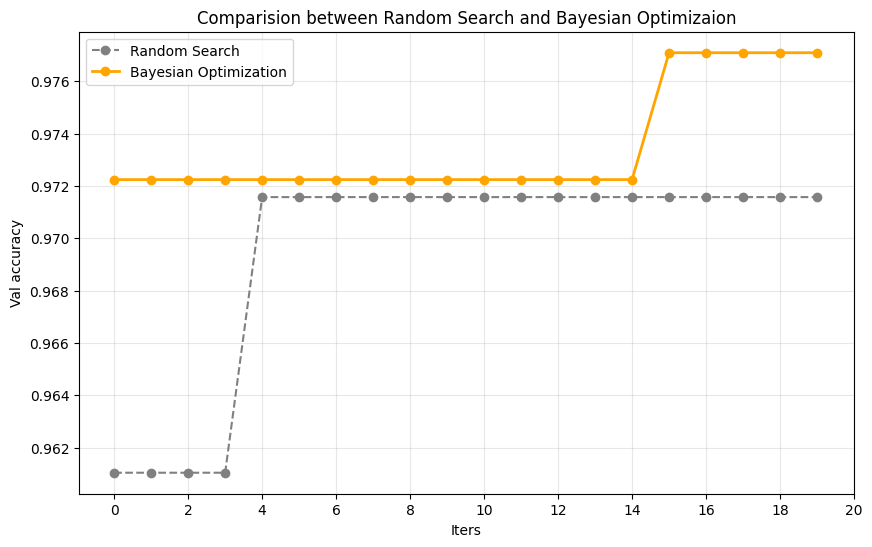

In [47]:
def get_accuracy(tuner):
    trials = sorted(tuner.oracle.trials.values(), key=lambda x: int(x.trial_id))
    best_acc = -1
    best_scores = []
    for t in trials:
        current_acc = t.score
        if current_acc is None:
            current_acc = 0

        if current_acc >= best_acc:
          best_acc = current_acc

        best_scores.append(best_acc)


    return best_scores

# Lấy dữ liệu 2 đội
acc_random = get_accuracy(tuner_random)
acc_bo = get_accuracy(tuner_BO)

# Vẽ
plt.figure(figsize=(10, 6))

plt.plot(acc_random, label='Random Search', marker='o', linestyle='--', color='gray')
plt.plot(acc_bo, label='Bayesian Optimization', marker='o', linestyle='-', color='orange', linewidth=2)
plt.xticks(range(0, len(acc_random) + 1, 2))
plt.title('Comparision between Random Search and Bayesian Optimizaion')
plt.xlabel('Iters')
plt.ylabel('Val accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

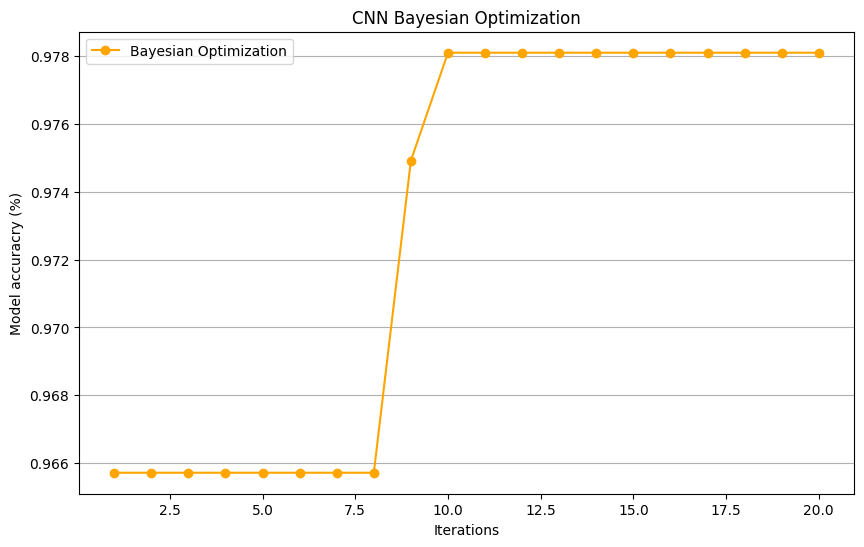

In [38]:
trials = tuner_BO.oracle.get_best_trials(num_trials=40) # Lấy hết 20

trials = sorted(trials, key=lambda x: int(x.trial_id))

iterations = []
accuracies = []
best_acc = -0.01

for i, trial in enumerate(trials):
    iterations.append(i + 1)

    current_acc = trial.score
    if current_acc == None:
        current_acc = 0

    if current_acc > best_acc:
        best_acc = current_acc
    accuracies.append(best_acc)


plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='orange', label='Bayesian Optimization')

plt.title('CNN Bayesian Optimization')
plt.xlabel('Iterations')
plt.ylabel('Model accuracry (%)')
plt.legend()
plt.grid(axis='y', zorder=0)
plt.show()

